Processing folder: /home/khare.aks/Dataset/combined/COVID/COVID
Processing folder: /home/khare.aks/Dataset/combined/NORMAL/NORMAL
Processing folder: /home/khare.aks/Dataset/combined/PNEUMONIA/PNEUMONIA
Processing folder: /home/khare.aks/Dataset/combined/Tuberculosis/Tuberculosis
Using device: cuda
ResNet101 Classification Report:
              precision    recall  f1-score   support

       COVID       1.00      0.99      1.00       154
      NORMAL       0.96      0.99      0.97       919
   PNEUMONIA       0.98      0.97      0.98       414
Tuberculosis       0.96      0.87      0.91       179

    accuracy                           0.97      1666
   macro avg       0.98      0.95      0.96      1666
weighted avg       0.97      0.97      0.97      1666

DenseNet121 Classification Report:
              precision    recall  f1-score   support

       COVID       0.97      0.99      0.98       154
      NORMAL       0.97      0.98      0.98       919
   PNEUMONIA       0.97      0.98  

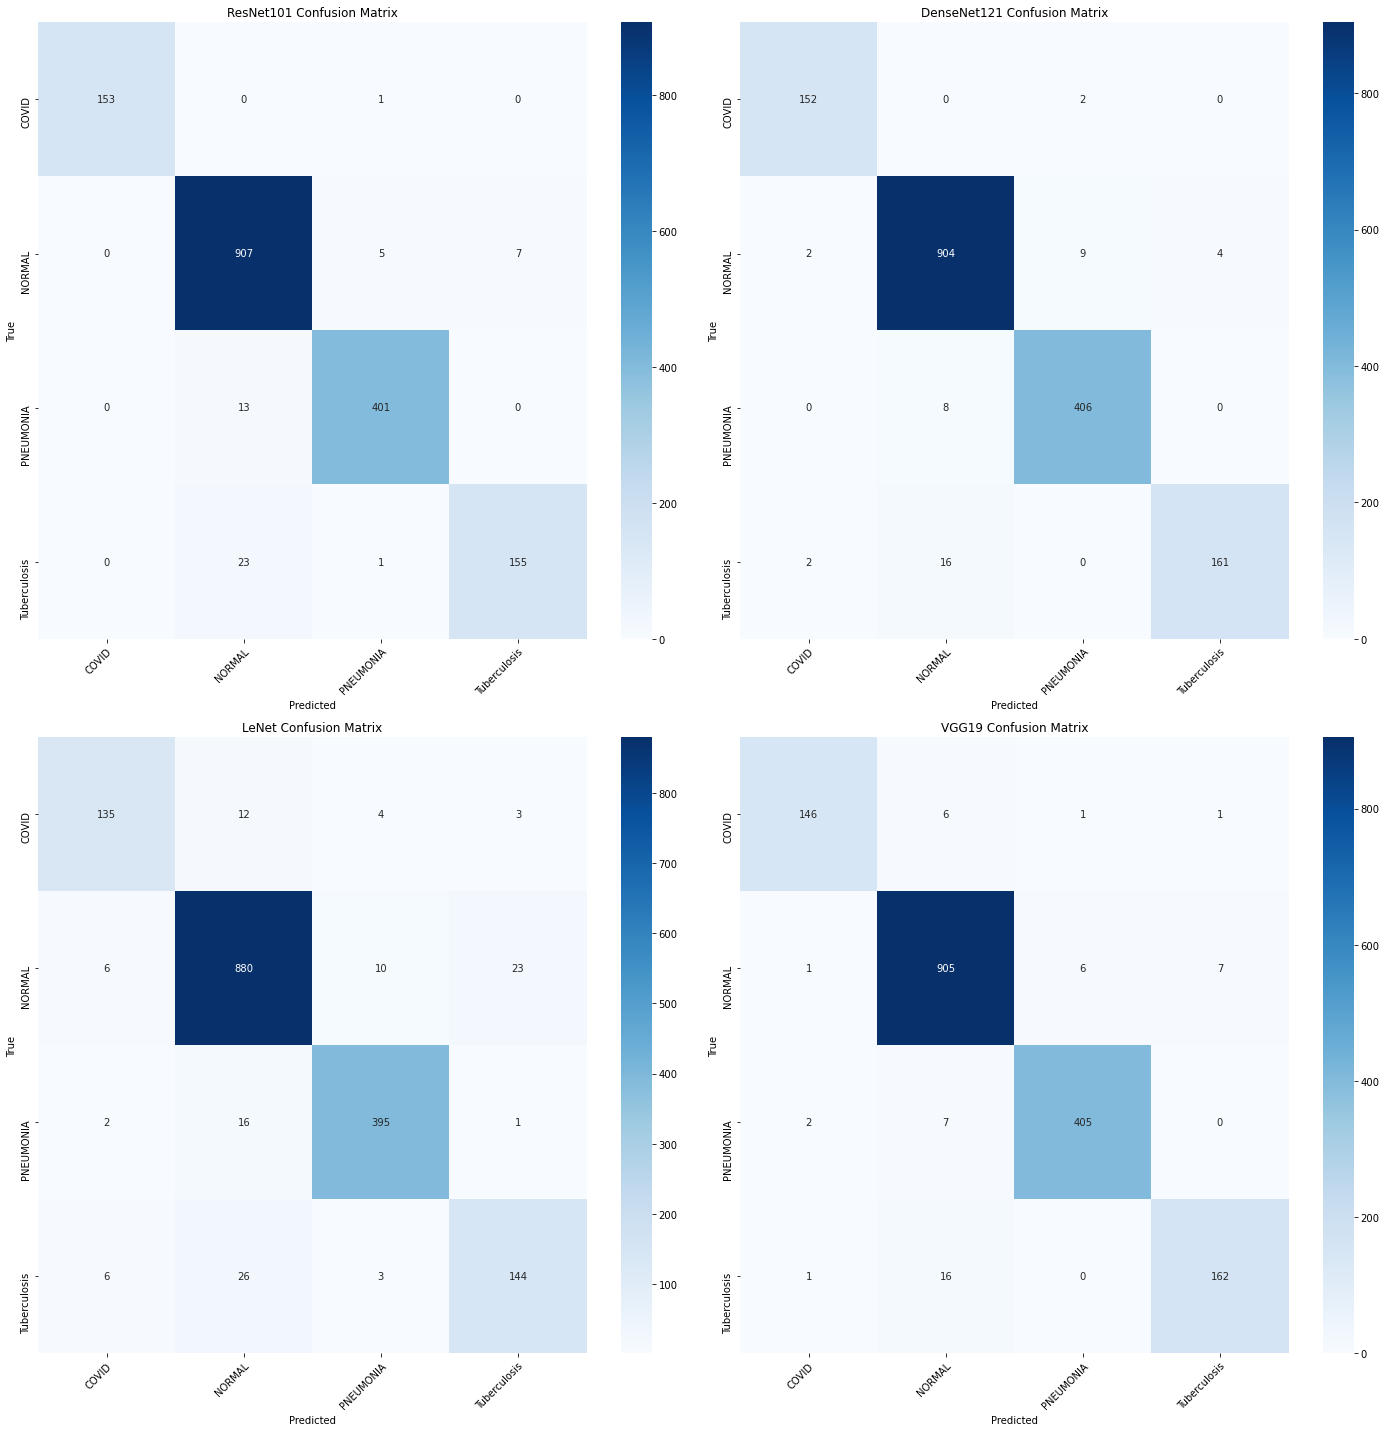

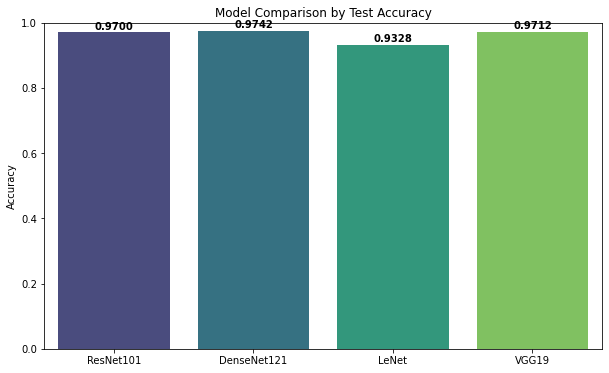

In [2]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pandas as pd

############################################################
# Define the dataset loading and splitting process
############################################################

data_dir = '/home/khare.aks/Dataset/combined/'
image_paths, labels = [], []

for folder in os.listdir(data_dir):
    outer_folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(outer_folder_path):
        inner_folder_path = os.path.join(outer_folder_path, folder)
        if os.path.isdir(inner_folder_path):
            print(f"Processing folder: {inner_folder_path}")
            for file in os.listdir(inner_folder_path):
                if file.endswith(('.jpg', '.png', '.jpeg')):
                    image_paths.append(os.path.join(inner_folder_path, file))
                    labels.append(folder)

# Create DataFrame and split data
data_frame = pd.DataFrame({'image_paths': image_paths, 'labels': labels})
strat = data_frame['labels']
train_df, semi_split_df = train_test_split(data_frame, train_size=0.8, shuffle=True, random_state=123, stratify=strat)
strat = semi_split_df['labels']
valid_df, test_df = train_test_split(semi_split_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)

# At this point, train_df, valid_df, and test_df are defined.

############################################################
# Prepare label mappings
############################################################
unique_labels = data_frame['labels'].unique()
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
idx_to_class = {v: k for k, v in label_mapping.items()}

############################################################
# Device setup
############################################################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

############################################################
# ImageDataset definition
############################################################

class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None, grayscale=False):
        self.dataframe = dataframe
        self.transform = transform
        self.class_to_idx = label_mapping
        self.grayscale = grayscale
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_paths']
        label = self.dataframe.iloc[idx]['labels']

        # Convert to grayscale if requested, else RGB
        mode = 'L' if self.grayscale else 'RGB'
        image = Image.open(img_path).convert(mode)
        
        if self.transform:
            image = self.transform(image)
        
        label_idx = self.class_to_idx[label]
        return image, label_idx

############################################################
# Data transforms
############################################################

# Transforms for RGB models
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Transforms for LeNet (grayscale, often expects 32x32 input)
lenet_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # single-channel normalization
])

batch_size = 16

# Test loader for RGB models
test_dataset = ImageDataset(test_df, transform=transform, grayscale=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Test loader for LeNet (grayscale)
lenet_test_dataset = ImageDataset(test_df, transform=lenet_transform, grayscale=True)
lenet_test_loader = DataLoader(lenet_test_dataset, batch_size=batch_size, shuffle=False)

num_classes = len(label_mapping)

############################################################
# Model definitions
############################################################

def get_resnet101_model(num_classes):
    model = models.resnet101(weights=None)
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, num_classes)
    )
    return model

class DenseNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(DenseNetClassifier, self).__init__()
        self.model = models.densenet121(weights=None)
        num_features = self.model.classifier.in_features
        self.model.classifier = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.model(x)

class LeNet(nn.Module):
    def __init__(self, num_classes):
        super(LeNet, self).__init__()
        # LeNet defined for single-channel input
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class VGG19Model(nn.Module):
    def __init__(self, num_classes):
        super(VGG19Model, self).__init__()
        self.vgg19 = models.vgg19(weights=None)
        self.vgg19.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )
    def forward(self, x):
        return self.vgg19(x)

############################################################
# Load the saved models
############################################################

resnet_model = get_resnet101_model(num_classes).to(device)
resnet_checkpoint = torch.load('resnet101_chest_xray_1.pth', map_location=device)
resnet_model.load_state_dict(resnet_checkpoint['model_state_dict'])
resnet_model.eval()

densenet_model = DenseNetClassifier(num_classes).to(device)
densenet_checkpoint = torch.load('densenet_chest_xray_1.pth', map_location=device)
densenet_model.load_state_dict(densenet_checkpoint['model_state_dict'])
densenet_model.eval()

lenet_model = LeNet(num_classes).to(device)
lenet_checkpoint = torch.load('lenet_best_model.pth', map_location=device)
lenet_model.load_state_dict(lenet_checkpoint)
lenet_model.eval()

vgg19_model = VGG19Model(num_classes).to(device)
vgg19_checkpoint = torch.load('vgg19_best_model_fixed.pth', map_location=device)
vgg19_model.load_state_dict(vgg19_checkpoint)
vgg19_model.eval()

############################################################
# Evaluation function
############################################################

def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

############################################################
# Evaluate models
############################################################

resnet_labels, resnet_preds = evaluate_model(resnet_model, test_loader, device)
densenet_labels, densenet_preds = evaluate_model(densenet_model, test_loader, device)
# For LeNet, use the grayscale loader:
lenet_labels, lenet_preds = evaluate_model(lenet_model, lenet_test_loader, device)
vgg19_labels, vgg19_preds = evaluate_model(vgg19_model, test_loader, device)

resnet_acc = accuracy_score(resnet_labels, resnet_preds)
densenet_acc = accuracy_score(densenet_labels, densenet_preds)
lenet_acc = accuracy_score(lenet_labels, lenet_preds)
vgg19_acc = accuracy_score(vgg19_labels, vgg19_preds)

print("ResNet101 Classification Report:")
print(classification_report(resnet_labels, resnet_preds, target_names=[idx_to_class[i] for i in range(num_classes)]))
print("DenseNet121 Classification Report:")
print(classification_report(densenet_labels, densenet_preds, target_names=[idx_to_class[i] for i in range(num_classes)]))
print("LeNet Classification Report:")
print(classification_report(lenet_labels, lenet_preds, target_names=[idx_to_class[i] for i in range(num_classes)]))
print("VGG19 Classification Report:")
print(classification_report(vgg19_labels, vgg19_preds, target_names=[idx_to_class[i] for i in range(num_classes)]))

resnet_cm = confusion_matrix(resnet_labels, resnet_preds)
densenet_cm = confusion_matrix(densenet_labels, densenet_preds)
lenet_cm = confusion_matrix(lenet_labels, lenet_preds)
vgg19_cm = confusion_matrix(vgg19_labels, vgg19_preds)

class_names = [idx_to_class[i] for i in range(num_classes)]

fig, axs = plt.subplots(2, 2, figsize=(20, 20))

def plot_confusion_matrix(cm, title, ax):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plot_confusion_matrix(resnet_cm, "ResNet101 Confusion Matrix", axs[0,0])
plot_confusion_matrix(densenet_cm, "DenseNet121 Confusion Matrix", axs[0,1])
plot_confusion_matrix(lenet_cm, "LeNet Confusion Matrix", axs[1,0])
plot_confusion_matrix(vgg19_cm, "VGG19 Confusion Matrix", axs[1,1])

plt.tight_layout()
plt.savefig('model_comparison_confusion_matrices.png')
plt.show()

model_names = ['ResNet101', 'DenseNet121', 'LeNet', 'VGG19']
accuracies = [resnet_acc, densenet_acc, lenet_acc, vgg19_acc]

plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=accuracies, palette='viridis')
plt.title("Model Comparison by Test Accuracy")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', fontweight='bold')
plt.savefig('model_comparison_accuracies.png')
plt.show()


In [3]:
print(resnet_model)
print(densenet_model)
print(lenet_model)
print(vgg19_model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
from torchinfo import summary

summary(resnet_model, input_size=(1, 3, 224, 224))
summary(densenet_model, input_size=(1, 3, 224, 224))
summary(vgg19_model, input_size=(1, 3, 224, 224))
summary(lenet_model, input_size=(1, 1, 32, 32))


Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [1, 4]                    --
├─Conv2d: 1-1                            [1, 6, 32, 32]            156
├─Conv2d: 1-2                            [1, 16, 12, 12]           2,416
├─Linear: 1-3                            [1, 120]                  69,240
├─Linear: 1-4                            [1, 84]                   10,164
├─Linear: 1-5                            [1, 4]                    340
Total params: 82,316
Trainable params: 82,316
Non-trainable params: 0
Total mult-adds (M): 0.59
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.33
Estimated Total Size (MB): 0.40

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image: /home/khare.aks/Dataset/combined/NORMAL/NORMAL/Normal-1988.png
True Label: NORMAL
Predicted Label: NORMAL



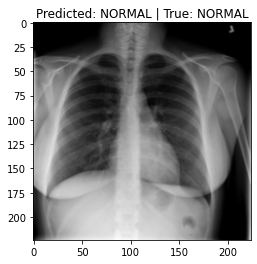

Image: /home/khare.aks/Dataset/combined/PNEUMONIA/PNEUMONIA/BACTERIA-2793790-0003.jpeg
True Label: PNEUMONIA
Predicted Label: PNEUMONIA



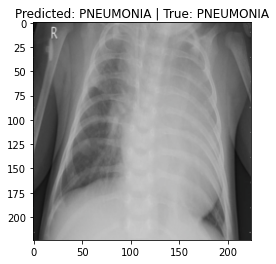

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image: /home/khare.aks/Dataset/combined/NORMAL/NORMAL/Normal-802.png
True Label: NORMAL
Predicted Label: NORMAL



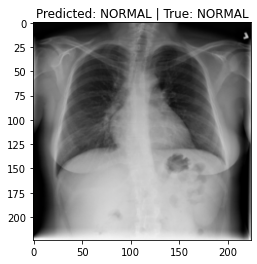

Image: /home/khare.aks/Dataset/combined/COVID/COVID/COVID_1544.png
True Label: COVID
Predicted Label: COVID



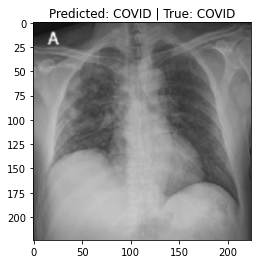

Image: /home/khare.aks/Dataset/combined/PNEUMONIA/PNEUMONIA/BACTERIA-2899476-0001.jpeg
True Label: PNEUMONIA
Predicted Label: PNEUMONIA



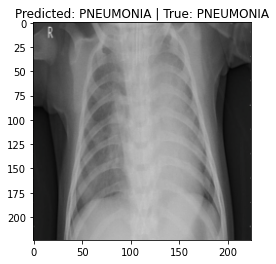

Image: /home/khare.aks/Dataset/combined/Tuberculosis/Tuberculosis/Tuberculosis-313.png
True Label: Tuberculosis
Predicted Label: Tuberculosis



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


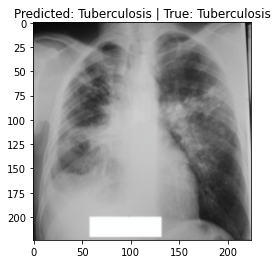

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image: /home/khare.aks/Dataset/combined/COVID/COVID/COVID_807.png
True Label: COVID
Predicted Label: COVID



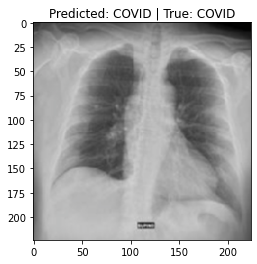

Image: /home/khare.aks/Dataset/combined/Tuberculosis/Tuberculosis/tb0142.png
True Label: Tuberculosis
Predicted Label: NORMAL



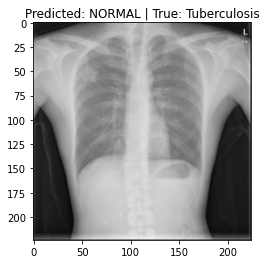

Image: /home/khare.aks/Dataset/combined/NORMAL/NORMAL/Normal-356.png
True Label: NORMAL
Predicted Label: NORMAL



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


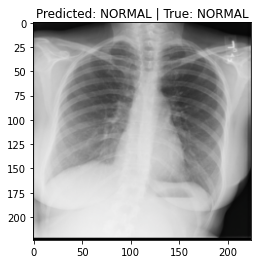

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image: /home/khare.aks/Dataset/combined/NORMAL/NORMAL/NORMAL-7397628-0002.jpeg
True Label: NORMAL
Predicted Label: NORMAL



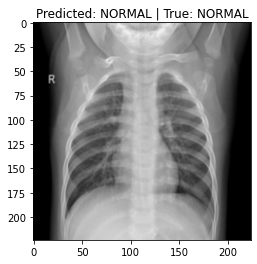

In [5]:
# Let's pick a few images from test_df to run inference on with the ResNet model
demo_images = test_df.sample(n=10, random_state=42)  # randomly pick 10 images

# Use the same transform for ResNet as training (RGB)
demo_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

resnet_model.eval()
with torch.no_grad():
    for idx, row in demo_images.iterrows():
        img_path = row['image_paths']
        true_label = row['labels']
        
        img = Image.open(img_path).convert('RGB')
        img_t = demo_transform(img).unsqueeze(0).to(device)

        output = resnet_model(img_t)
        _, pred = torch.max(output, 1)
        pred_label = idx_to_class[pred.item()]

        print(f"Image: {img_path}")
        print(f"True Label: {true_label}")
        print(f"Predicted Label: {pred_label}\n")

        # Optionally, display the image inline (if running in a notebook)
        plt.imshow(np.transpose(img_t.cpu().squeeze().numpy(), (1,2,0))*np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406]))
        plt.title(f"Predicted: {pred_label} | True: {true_label}")
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image: /home/khare.aks/Dataset/combined/NORMAL/NORMAL/Normal-1988.png
True Label: NORMAL
Predicted Label: NORMAL



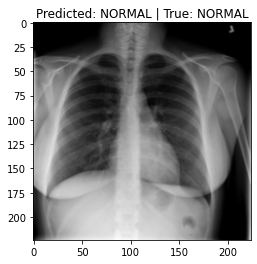

Image: /home/khare.aks/Dataset/combined/PNEUMONIA/PNEUMONIA/BACTERIA-2793790-0003.jpeg
True Label: PNEUMONIA
Predicted Label: PNEUMONIA



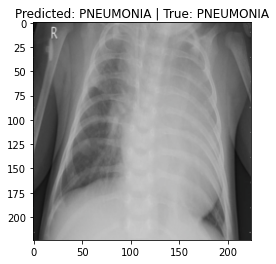

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image: /home/khare.aks/Dataset/combined/NORMAL/NORMAL/Normal-802.png
True Label: NORMAL
Predicted Label: NORMAL



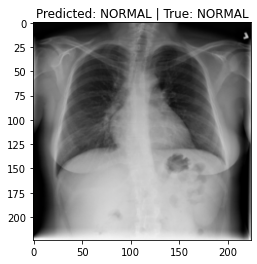

Image: /home/khare.aks/Dataset/combined/COVID/COVID/COVID_1544.png
True Label: COVID
Predicted Label: COVID



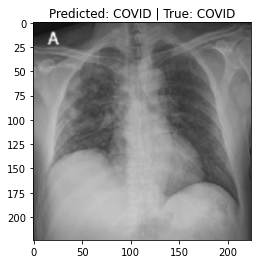

Image: /home/khare.aks/Dataset/combined/PNEUMONIA/PNEUMONIA/BACTERIA-2899476-0001.jpeg
True Label: PNEUMONIA
Predicted Label: PNEUMONIA



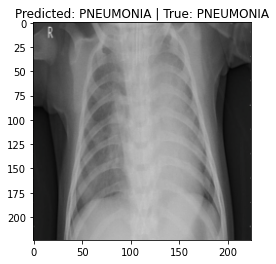

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image: /home/khare.aks/Dataset/combined/Tuberculosis/Tuberculosis/Tuberculosis-313.png
True Label: Tuberculosis
Predicted Label: Tuberculosis



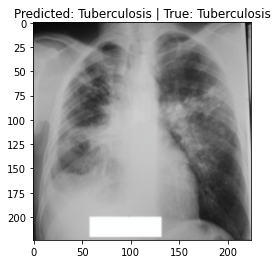

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image: /home/khare.aks/Dataset/combined/COVID/COVID/COVID_807.png
True Label: COVID
Predicted Label: COVID



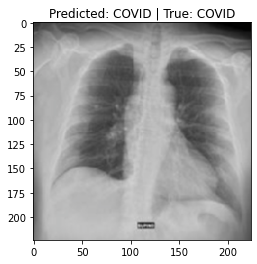

Image: /home/khare.aks/Dataset/combined/Tuberculosis/Tuberculosis/tb0142.png
True Label: Tuberculosis
Predicted Label: NORMAL



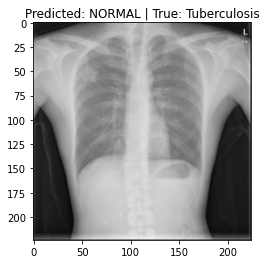

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image: /home/khare.aks/Dataset/combined/NORMAL/NORMAL/Normal-356.png
True Label: NORMAL
Predicted Label: NORMAL



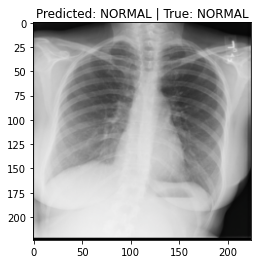

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image: /home/khare.aks/Dataset/combined/NORMAL/NORMAL/NORMAL-7397628-0002.jpeg
True Label: NORMAL
Predicted Label: NORMAL



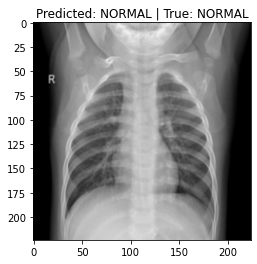

In [6]:
# Let's pick a few images from test_df to run inference on with the DenseNet model
demo_images = test_df.sample(n=10, random_state=42)  # randomly pick 10 images

# Use the same transform for ResNet as training (RGB)
demo_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

densenet_model.eval()
with torch.no_grad():
    for idx, row in demo_images.iterrows():
        img_path = row['image_paths']
        true_label = row['labels']
        
        img = Image.open(img_path).convert('RGB')
        img_t = demo_transform(img).unsqueeze(0).to(device)

        output = resnet_model(img_t)
        _, pred = torch.max(output, 1)
        pred_label = idx_to_class[pred.item()]

        print(f"Image: {img_path}")
        print(f"True Label: {true_label}")
        print(f"Predicted Label: {pred_label}\n")

        # Optionally, display the image inline (if running in a notebook)
        plt.imshow(np.transpose(img_t.cpu().squeeze().numpy(), (1,2,0))*np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406]))
        plt.title(f"Predicted: {pred_label} | True: {true_label}")
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image: /home/khare.aks/Dataset/combined/NORMAL/NORMAL/Normal-1988.png
True Label: NORMAL
Predicted Label: NORMAL



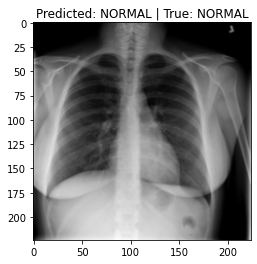

Image: /home/khare.aks/Dataset/combined/PNEUMONIA/PNEUMONIA/BACTERIA-2793790-0003.jpeg
True Label: PNEUMONIA
Predicted Label: PNEUMONIA



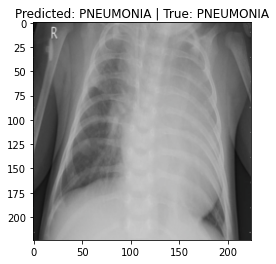

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image: /home/khare.aks/Dataset/combined/NORMAL/NORMAL/Normal-802.png
True Label: NORMAL
Predicted Label: NORMAL



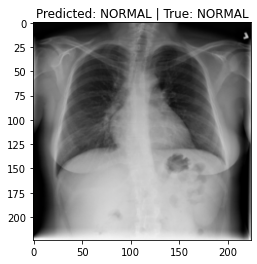

Image: /home/khare.aks/Dataset/combined/COVID/COVID/COVID_1544.png
True Label: COVID
Predicted Label: COVID



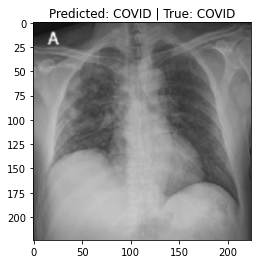

Image: /home/khare.aks/Dataset/combined/PNEUMONIA/PNEUMONIA/BACTERIA-2899476-0001.jpeg
True Label: PNEUMONIA
Predicted Label: PNEUMONIA



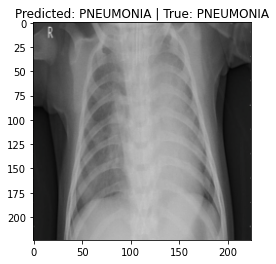

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image: /home/khare.aks/Dataset/combined/Tuberculosis/Tuberculosis/Tuberculosis-313.png
True Label: Tuberculosis
Predicted Label: Tuberculosis



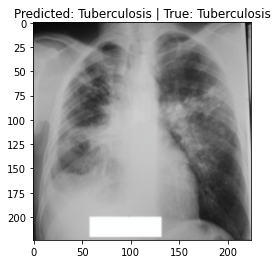

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image: /home/khare.aks/Dataset/combined/COVID/COVID/COVID_807.png
True Label: COVID
Predicted Label: COVID



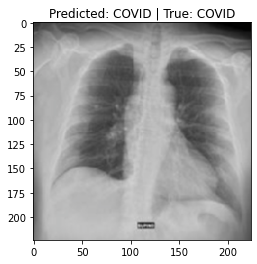

Image: /home/khare.aks/Dataset/combined/Tuberculosis/Tuberculosis/tb0142.png
True Label: Tuberculosis
Predicted Label: NORMAL



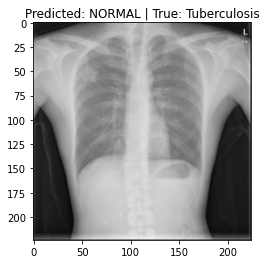

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image: /home/khare.aks/Dataset/combined/NORMAL/NORMAL/Normal-356.png
True Label: NORMAL
Predicted Label: NORMAL



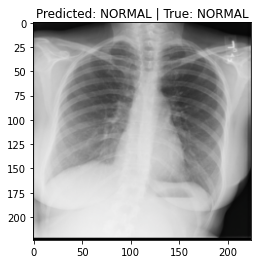

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image: /home/khare.aks/Dataset/combined/NORMAL/NORMAL/NORMAL-7397628-0002.jpeg
True Label: NORMAL
Predicted Label: NORMAL



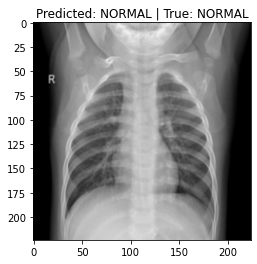

In [7]:
# Let's pick a few images from test_df to run inference on with the LeNet model
demo_images = test_df.sample(n=10, random_state=42)  # randomly pick 10 images

# Use the same transform for ResNet as training (RGB)
demo_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

lenet_model.eval()
with torch.no_grad():
    for idx, row in demo_images.iterrows():
        img_path = row['image_paths']
        true_label = row['labels']
        
        img = Image.open(img_path).convert('RGB')
        img_t = demo_transform(img).unsqueeze(0).to(device)

        output = resnet_model(img_t)
        _, pred = torch.max(output, 1)
        pred_label = idx_to_class[pred.item()]

        print(f"Image: {img_path}")
        print(f"True Label: {true_label}")
        print(f"Predicted Label: {pred_label}\n")

        # Optionally, display the image inline (if running in a notebook)
        plt.imshow(np.transpose(img_t.cpu().squeeze().numpy(), (1,2,0))*np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406]))
        plt.title(f"Predicted: {pred_label} | True: {true_label}")
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image: /home/khare.aks/Dataset/combined/NORMAL/NORMAL/Normal-1988.png
True Label: NORMAL
Predicted Label: NORMAL



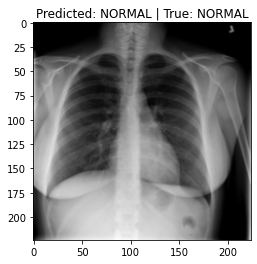

Image: /home/khare.aks/Dataset/combined/PNEUMONIA/PNEUMONIA/BACTERIA-2793790-0003.jpeg
True Label: PNEUMONIA
Predicted Label: PNEUMONIA



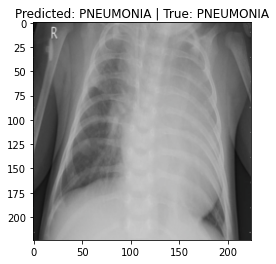

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image: /home/khare.aks/Dataset/combined/NORMAL/NORMAL/Normal-802.png
True Label: NORMAL
Predicted Label: NORMAL



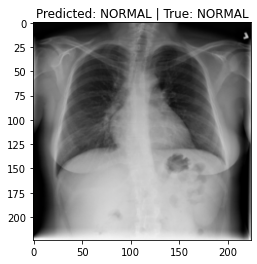

Image: /home/khare.aks/Dataset/combined/COVID/COVID/COVID_1544.png
True Label: COVID
Predicted Label: COVID



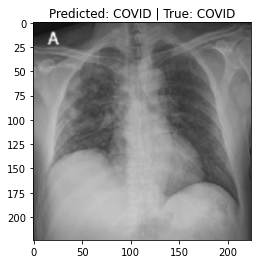

Image: /home/khare.aks/Dataset/combined/PNEUMONIA/PNEUMONIA/BACTERIA-2899476-0001.jpeg
True Label: PNEUMONIA
Predicted Label: PNEUMONIA



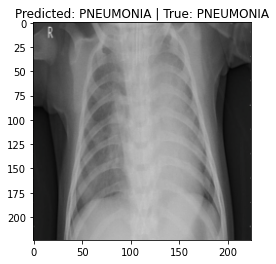

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image: /home/khare.aks/Dataset/combined/Tuberculosis/Tuberculosis/Tuberculosis-313.png
True Label: Tuberculosis
Predicted Label: Tuberculosis



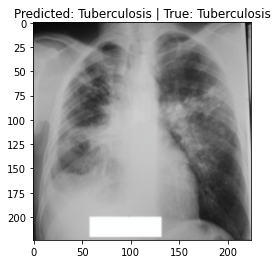

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image: /home/khare.aks/Dataset/combined/COVID/COVID/COVID_807.png
True Label: COVID
Predicted Label: COVID



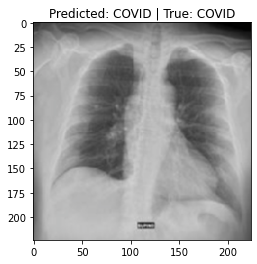

Image: /home/khare.aks/Dataset/combined/Tuberculosis/Tuberculosis/tb0142.png
True Label: Tuberculosis
Predicted Label: NORMAL



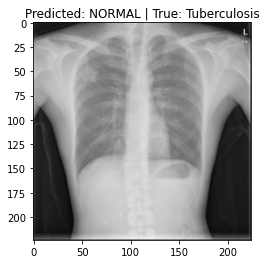

Image: /home/khare.aks/Dataset/combined/NORMAL/NORMAL/Normal-356.png
True Label: NORMAL
Predicted Label: NORMAL



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


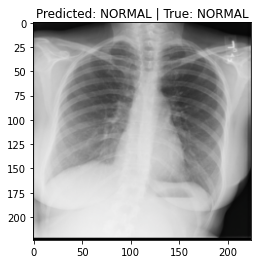

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image: /home/khare.aks/Dataset/combined/NORMAL/NORMAL/NORMAL-7397628-0002.jpeg
True Label: NORMAL
Predicted Label: NORMAL



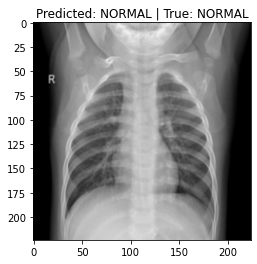

In [8]:
# Let's pick a few images from test_df to run inference on with the VGG19 model
demo_images = test_df.sample(n=10, random_state=42)  # randomly pick 10 images

# Use the same transform for ResNet as training (RGB)
demo_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

vgg19_model.eval()
with torch.no_grad():
    for idx, row in demo_images.iterrows():
        img_path = row['image_paths']
        true_label = row['labels']
        
        img = Image.open(img_path).convert('RGB')
        img_t = demo_transform(img).unsqueeze(0).to(device)

        output = resnet_model(img_t)
        _, pred = torch.max(output, 1)
        pred_label = idx_to_class[pred.item()]

        print(f"Image: {img_path}")
        print(f"True Label: {true_label}")
        print(f"Predicted Label: {pred_label}\n")

        # Optionally, display the image inline (if running in a notebook)
        plt.imshow(np.transpose(img_t.cpu().squeeze().numpy(), (1,2,0))*np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406]))
        plt.title(f"Predicted: {pred_label} | True: {true_label}")
        plt.show()